In [1]:
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
import astropy.units as u
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [14]:
def query_stars(load=False):
    """
    Query Gaia DR3 for stars within a specified radius of given coordinates,
    filtering for stars with proper motion greater than pm_thresh.

    Parameters:

    Returns:
    - Pandas DataFrame containing the Gaia stars meeting the criteria.
    """

    # Construct query to get distance to the object by getting parralax of the closest star
    if load:
        df = pd.read_csv('d_query.csv')
    else:
        distance_query = """
        SELECT *
        FROM gaiadr3.gaia_source
        WHERE   parallax_over_error > 20
            AND (1000/parallax) < 100
        """
        print("Querying Gaia Archive for distance... This may take a few seconds.")
        # Row limit -1
        Gaia.ROW_LIMIT = -1
        dist_job = Gaia.launch_job_async(distance_query)
        dist_results = dist_job.get_results()
        df = dist_results.to_pandas()

        # Save the df
        df.to_csv('d_query.csv')

    return df

df = query_stars(load=True)

Querying Gaia Archive for distance... This may take a few seconds.
INFO: Query finished. [astroquery.utils.tap.core]


In [28]:
# Plot color-magnitude diagram
points = {
    'p0': (-1,5),
    'p1': (1,13),
    'p2': (2,17.5),
    'p3': (3,20),
    'p4': (4,22),
}
line_seg = []

for i in range(len(points) - 1):
    x_i = ((points[f'p{i}'], points[f'p{i+1}']))
    line_seg.append(x_i)


In [29]:

def count_stars_above_line(data, line_segments):
    num_outliers = 0
    outlier_indices = []

    for idx, row in data.iterrows():
        x_star, y_star = row['bp_rp'], row['phot_g_mean_mag']

        # Find the corresponding line segment
        for (x1, y1), (x2, y2) in line_segments:
            if x1 <= x_star <= x2:  # Check if star is within segment range
                # Linear interpolation of y on the line segment
                y_line = y1 + (y2 - y1) * (x_star - x1) / (x2 - x1)

                # Check if star is below the line (fainter magnitude)
                if y_star > y_line:
                    num_outliers += 1
                    outlier_indices.append(idx)
                break  # Each star can be checked in one segment at most

    result_dict = {
        'num_outliers': num_outliers,
        'outlier_indices': outlier_indices,
    }

    return result_dict

In [25]:
res = count_stars_above_line(df, line_seg)
print(f"Number of stars below the line: {res['num_outliers']}")

Number of stars below the line: 186522


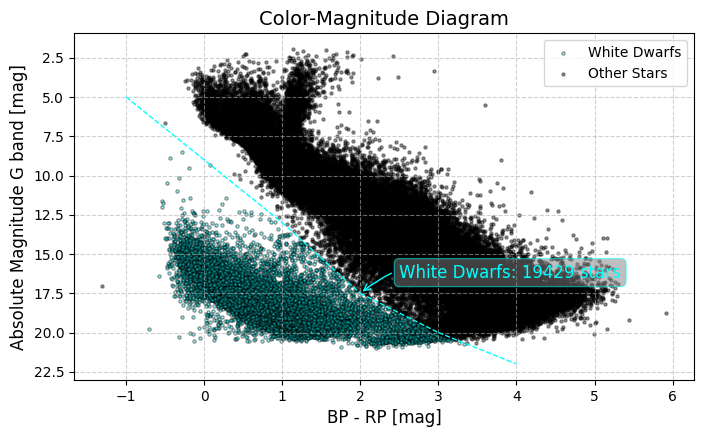

In [33]:
# Make a color magnitude diagram
def plot_color_magnitude_diagram(r, 
                                 line_segments=None, 
                                 ssize=5,
                                 boring_plot=False,
                                 ot_line_color='cyan',
                                 ):

    

    # Extract necessary columns (g band magnitude and bp-rp color)
    abs_mag_col = 'phot_g_mean_mag'
    color_col = 'bp_rp'

    # Create a color map based on the BP-RP color index
    colors = r['parallax_error']

    

    # Create the plot
    fig, ax = plt.subplots(figsize=(16/2., 9/2.))

    if line_segments:
        hw_part = 'c'
        result_dict = count_stars_above_line(r, line_segments)

        # Plot the outliers
        ot_indices = result_dict['outlier_indices']
        ax.scatter(
            r[color_col].iloc[ot_indices],
            r[abs_mag_col].iloc[ot_indices],
            s=ssize,
            c=ot_line_color,
            alpha=0.4,
            edgecolor='k',
            label='White Dwarfs'
        )

        # Plot the rest of the stars
        ax.scatter(
            r[color_col].drop(index=ot_indices),
            r[abs_mag_col].drop(index=ot_indices),
            s=ssize,
            c='black',
            alpha=0.4,
            edgecolor='k',
            label='Other Stars'
        )


        for segment in line_segments:
            (x1, y1), (x2, y2) = segment
            ax.plot([x1, x2], [y1, y2],c=ot_line_color, linestyle='--', linewidth=1,
                    )
            
    # Add annotation for the number of outliers line

        chose_pnt = line_segments[len(line_segments)//2][0]
        num_outliers = result_dict['num_outliers']
        ot_text = f'White Dwarfs: {num_outliers} stars'
        
        ax.annotate(ot_text,
             c=ot_line_color,
             xy=(chose_pnt[0], chose_pnt[1]),
             xytext=(chose_pnt[0] + 0.5, chose_pnt[1] - 1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3', color=ot_line_color),
             fontsize=12,
             bbox=dict(boxstyle='round', facecolor='grey', edgecolor=ot_line_color, alpha=0.5)
             )
        
        
    if boring_plot:
        hw_part = 'b'
        scatter = ax.scatter(
        r[color_col],
        r[abs_mag_col], 
        s=ssize, 
        c=colors, 
        alpha=0.4,  # Increase transparency
        edgecolor='k',  # Optional for clarity
        label='Cluster Stars',
        cmap='plasma',
        norm=LogNorm()  # Apply logarithmic normalization
         )
        # Add a color bar to show the colormap scale
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label(r'Parallax Error', fontsize=12)
        
    ax.set_xlabel('BP - RP [mag]', fontsize=12)
    ax.set_ylabel('Absolute Magnitude G band [mag]', fontsize=12)
    ax.set_title('Color-Magnitude Diagram', fontsize=14)
    ax.invert_yaxis()
    ax.grid(True, linestyle='--', alpha=0.6)


    ax.legend()

    plt.savefig(f'cmd_part_{hw_part}.png', dpi=400, bbox_inches='tight')

    plt.show()

plot_color_magnitude_diagram(df, line_segments=line_seg, boring_plot=False)


In [ ]:
def query_sdss_xmatch(load=False):
    """
    Query Gaia DR3 for stars within a specified radius of given coordinates,
    filtering for stars with proper motion greater than pm_thresh.

    Parameters:

    Returns:
    - Pandas DataFrame containing the Gaia stars meeting the criteria.
    """
    if load:
        df = pd.read_csv('sdss_xmatch_query.csv')
    else:
        distance_query = """
        SELECT g.phot_g_mean_mag, g.phot_bp_mean_mag, g.phot_rp_mean_mag,
                g.parallax, 
                q_sdss.objid, q_sdss.u, q_sdss.g, q_sdss.r, q_sdss.i, q_sdss.z


        FROM gaiadr3.sdssdr13_best_neighbour as best_neighbour

        INNER JOIN gaiadr3.gaia_source as g ON g.source_id = best_neighbour.source_id

        INNER JOIN external.sdssdr13_photoprimary as q_sdss ON q_sdss.objid = best_neighbour.original_ext_source_id

        WHERE (g.parallax > 10) 
        AND (g.phot_bp_mean_flux_over_error > 20) 
        AND (g.phot_rp_mean_flux_over_error > 20) 
        AND (g.parallax_over_error > 20)
        """
        print("Querying Gaia Archive for distance... This may take a few seconds.")
        # Row limit -1
        Gaia.ROW_LIMIT = -1
        dist_job = Gaia.launch_job_async(distance_query)
        dist_results = dist_job.get_results()
        df = dist_results.to_pandas()

        # Save the df
        df.to_csv('sdss_xmatch_query.csv')

    return df

sdss_df = query_stars(load=True)

Querying Gaia Archive for distance... This may take a few seconds.


KeyboardInterrupt: 

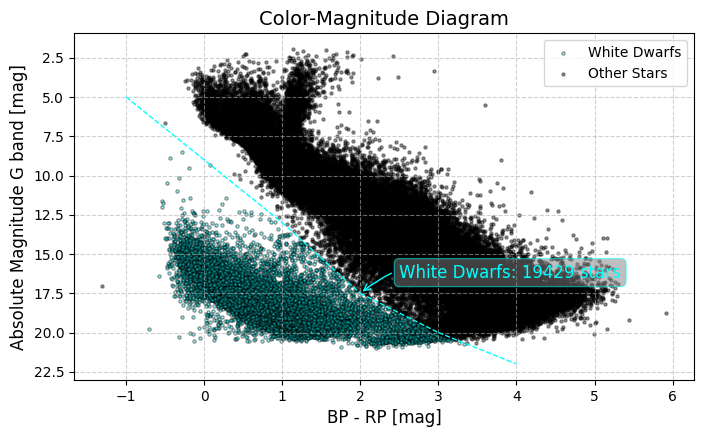

In [38]:
plot_color_magnitude_diagram(sdss_df, line_segments=line_seg, boring_plot=False)

In [41]:
for i in sdss_df.columns:
    print(i)

solution_id
designation
source_id
random_index
ref_epoch
ra
ra_error
dec
dec_error
parallax
parallax_error
parallax_over_error
pm
pmra
pmra_error
pmdec
pmdec_error
ra_dec_corr
ra_parallax_corr
ra_pmra_corr
ra_pmdec_corr
dec_parallax_corr
dec_pmra_corr
dec_pmdec_corr
parallax_pmra_corr
parallax_pmdec_corr
pmra_pmdec_corr
astrometric_n_obs_al
astrometric_n_obs_ac
astrometric_n_good_obs_al
astrometric_n_bad_obs_al
astrometric_gof_al
astrometric_chi2_al
astrometric_excess_noise
astrometric_excess_noise_sig
astrometric_params_solved
astrometric_primary_flag
nu_eff_used_in_astrometry
pseudocolour
pseudocolour_error
ra_pseudocolour_corr
dec_pseudocolour_corr
parallax_pseudocolour_corr
pmra_pseudocolour_corr
pmdec_pseudocolour_corr
astrometric_matched_transits
visibility_periods_used
astrometric_sigma5d_max
matched_transits
new_matched_transits
matched_transits_removed
ipd_gof_harmonic_amplitude
ipd_gof_harmonic_phase
ipd_frac_multi_peak
ipd_frac_odd_win
ruwe
scan_direction_strength_k1
scan_di

In [43]:
sdss_df.to_csv('sdss_df.csv')